<a href="https://colab.research.google.com/github/jblcky/retail-inventory-forecasting-2/blob/main/notebooks/model_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model Preparation**
- import library
- pandas, numpy → for data wrangling
- sklearn modules → used for data preprocessing, model building, and saving pipelines
- joblib → saves your trained model and preprocessing pipeline for future reuse

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib


In [ ]:
url = 'https://raw.githubusercontent.com/jblcky/retail-inventory-forecasting-2/refs/heads/main/data/processed/sales_df_fe.csv'
# Load processed file
sales_df = pd.read_csv(url, parse_dates=["date"])

**Define Features and Target**
- features: Includes temporal, product, price, and event-based drivers of demand.
- target: We're predicting quantity_sold — you can later extend this to predict revenue, stockout_risk, etc.

In [ ]:
features = [
    'store_id', 'sku_id', 'day_of_week', 'weekofyear', 'month', 'year',
    'is_weekend', 'is_holiday', 'is_school_holiday', 'is_flu_season',
    'price', 'on_promo', 'days_to_expiry', 'rolling_7d_sales'
]

target = 'quantity_sold'


print to verify

In [ ]:
sales_df[features + [target]].head()


,store_id,sku_id,day_of_week,weekofyear,month,year,is_weekend,is_holiday,is_school_holiday,is_flu_season,price,on_promo,days_to_expiry,rolling_7d_sales,quantity_sold
0,Store_A,SKU_001,0,1,1,2024,False,True,False,False,16.236204,0,999,0.0,45
1,Store_A,SKU_001,1,1,1,2024,False,False,False,False,33.521429,0,999,0.0,51
2,Store_A,SKU_001,2,1,1,2024,False,False,False,False,26.959818,0,999,0.0,51
3,Store_A,SKU_001,3,1,1,2024,False,False,False,False,22.959755,0,999,0.0,57
4,Store_A,SKU_001,4,1,1,2024,False,False,False,False,9.680559,0,999,0.0,46


In [ ]:
X = sales_df[features]
y = sales_df[target]

Train-Test Split (Time-Aware)
- Time-based split avoids "peeking into the future," which would make the model unrealistically good.

- This simulates real-world deployment: train on past, test on unseen future.

- This avoids data leakage by ensuring test data is after train data chronologically.

In [ ]:
# Sort by date to simulate real-world forecasting
sales_df = sales_df.sort_values('date')

# Use 80% for training, 20% for testing
split_idx = int(len(sales_df) * 0.8)
train_df = sales_df.iloc[:split_idx]
test_df = sales_df.iloc[split_idx:]

# Split into X and y
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


Preprocessing Pipeline
- StandardScaler() → scales numeric columns to mean=0, std=1 for better model performance.

- OneHotEncoder() → turns categorical features into binary vectors (e.g., day_of_week=Mon becomes [1, 0, 0, 0, 0, 0, 0])

- ColumnTransformer → applies these operations column-wise cleanly.

In [ ]:
categorical = ['store_id', 'sku_id', 'day_of_week', 'month']
numeric = ['price', 'days_to_expiry']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])


Build a Modeling Pipeline (with XGBoost)
- Pipeline chains preprocessing + modeling into one clean object.

- XGBRegressor is fast, robust to overfitting, and handles missing values (if any).

- You can easily swap models later (e.g., LightGBM or RandomForest).


In [ ]:
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ))
])


Train the Model
- Trains the full pipeline: first transforms the data, then fits the model.

- You can now evaluate predictions using xgb_model.predict(X_test).

In [ ]:
xgb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price', 'days_to_expiry']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['store_id', 'sku_id',
                                                   'day_of_week', 'month'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, devic...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [ ]:
xgb_preds = xgb_model.predict(X_test)

In [ ]:
# Evaluate performance using RMSE and MAE
# Calculate MSE first, then take the square root for RMSE
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)

xgb_mae = mean_absolute_error(y_test, xgb_preds)

print(f"🔹 Xgb RMSE: {xgb_rmse:.2f}")
print(f"🔹 Xgb MAE: {xgb_mae:.2f}")

🔹 Xgb RMSE: 6.39
🔹 Xgb MAE: 5.08


In [ ]:
X_train.head(10)

,store_id,sku_id,day_of_week,weekofyear,month,year,is_weekend,is_holiday,is_school_holiday,is_flu_season,price,on_promo,days_to_expiry,rolling_7d_sales
0,Store_A,SKU_001,0,1,1,2024,False,True,False,False,16.236204,0,999,0.0
2160,Store_A,SKU_007,0,1,1,2024,False,True,False,False,24.534428,0,999,0.0
540,Store_B,SKU_002,0,1,1,2024,False,True,False,False,33.621531,0,999,0.0
1980,Store_B,SKU_006,0,1,1,2024,False,True,False,False,10.583043,0,999,0.0
1080,Store_A,SKU_004,0,1,1,2024,False,True,False,False,28.590350,0,999,0.0
1620,Store_B,SKU_005,0,1,1,2024,False,True,False,False,18.956168,0,999,0.0
720,Store_A,SKU_003,0,1,1,2024,False,True,False,False,33.150214,0,999,0.0
2520,Store_A,SKU_008,0,1,1,2024,False,True,False,False,25.775973,0,999,0.0
180,Store_B,SKU_001,0,1,1,2024,False,True,False,False,15.231991,0,999,0.0
2700,Store_B,SKU_008,0,1,1,2024,False,True,False,False,20.638881,0,999,0.0


Problem:
Linear models require all features to be numerical, but your dataset contains string-based categorical features like:

- 'sku_id'

- 'store_id'

- Possibly others (e.g. 'day_of_week' if it’s still a string)

There are 2 common ways:

- Label Encoding – simpler, but assumes order (not always ideal).

- One-Hot Encoding – recommended for linear models, creates binary columns (e.g., store_A, store_B, etc.).

- Let’s go with One-Hot Encoding using pd.get_dummies.

drop_first=True avoids multicollinearity.

We encode after splitting to avoid data leakage, but we fit the encoding on the combined set so the one-hot columns match.

In [ ]:
# Combine training and test data to apply consistent encoding
X_full = pd.concat([X_train, X_test], axis=0)

# Identify categorical columns
cat_cols = ['sku_id', 'store_id']  # Add more if needed

# Apply one-hot encoding
X_full_encoded = pd.get_dummies(X_full, columns=cat_cols, drop_first=True)

# Re-split back into train and test
X_train_encoded = X_full_encoded.iloc[:len(X_train), :]
X_test_encoded = X_full_encoded.iloc[len(X_train):, :]


**Linear Regression – Basic Model**
- Why Linear Regression? It's a fast, interpretable baseline. If it performs reasonably well, it means your features already carry useful signal.

- RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) are commonly used metrics for regression problems — lower is better.
- RMSE penalizes large errors.

- MAE gives average magnitude of errors.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the linear regression model
lr_model = LinearRegression()

# Train the model using the training data
lr_model.fit(X_train_encoded, y_train)

# Predict on the test data
lr_preds = lr_model.predict(X_test_encoded)

# Evaluate performance using RMSE and MAE
# Calculate MSE first, then take the square root for RMSE
lr_mse = mean_squared_error(y_test, lr_preds)
lr_rmse = np.sqrt(lr_mse)

lr_mae = mean_absolute_error(y_test, lr_preds)

print(f"🔹 Linear Regression RMSE: {lr_rmse:.2f}")
print(f"🔹 Linear Regression MAE: {lr_mae:.2f}")


🔹 Linear Regression RMSE: 7.54
🔹 Linear Regression MAE: 6.19


**Random Forest – Non-Linear Baseline**
- Random Forest is a strong, non-linear model. It captures complex interactions between features.

- We use 100 trees and n_jobs=-1 to parallelize computation.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train_encoded, y_train)

# Predict on the test data
rf_preds = rf_model.predict(X_test_encoded)

# Evaluate
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(lr_mse)

rf_mae = mean_absolute_error(y_test, rf_preds)

print(f"🌲 Random Forest RMSE: {rf_rmse:.2f}")
print(f"🌲 Random Forest MAE: {rf_mae:.2f}")


🌲 Random Forest RMSE: 7.54
🌲 Random Forest MAE: 4.86


Compare Model Performances
- A results table makes it easy to track performance across different models.

- We'll improve on these scores using tuning, advanced models, and feature engineering later.

In [ ]:
# Create a table of results
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [lr_rmse, rf_rmse],
    'MAE': [lr_mae, rf_mae]
})

# Sort by RMSE (lower is better)
results_df.sort_values('RMSE', ascending=True)


,Model,RMSE,MAE
0,Linear Regression,7.536211,6.189423
1,Random Forest,7.536211,4.859222


Visual Check – Predicted vs Actual (Random Forest)
- Visual inspection helps detect if the model underpredicts or overpredicts consistently.

- This sample of 100 is just to keep the plot readable. You can expand it as needed.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


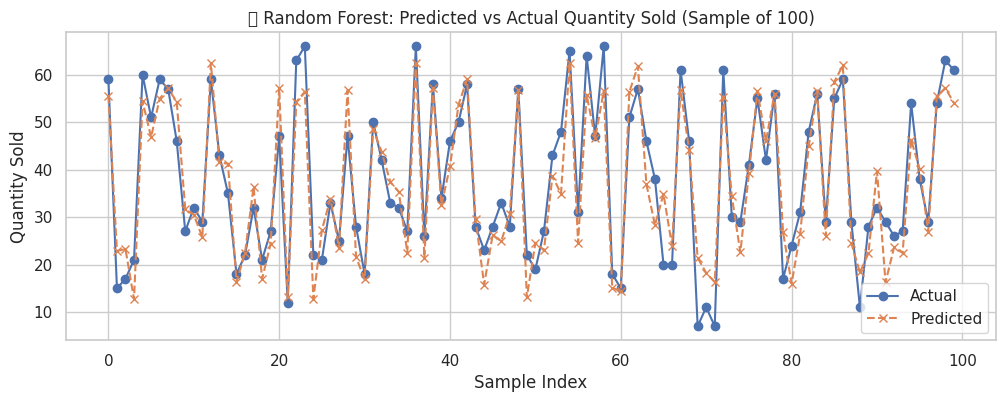

In [ ]:
import matplotlib.pyplot as plt

# Plot a small sample of predictions vs actuals
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(rf_preds[:100], label='Predicted', linestyle='--', marker='x')
plt.legend()
plt.title("📊 Random Forest: Predicted vs Actual Quantity Sold (Sample of 100)")
plt.xlabel("Sample Index")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.show()


lightgbm baseline model
- Forecasting demand to prevent stockouts using LightGBM — a fast, efficient gradient boosting model.
- Install and Import LightGBM
- LightGBM is a fast and powerful tree-based gradient boosting framework often used in Kaggle competitions and real-world forecasting tasks.



In [ ]:
# Install LightGBM if not already installed
!pip install lightgbm -q

# Import LightGBM and evaluation metrics
import lightgbm as lgb

Prepare LightGBM Dataset Format
- This converts pandas DataFrames into LightGBM’s internal format, which improves training performance and enables advanced features like categorical handling (if needed).

In [ ]:
# Convert to LightGBM's efficient dataset format
lgb_train = lgb.Dataset(X_train_encoded, label=y_train)
lgb_test = lgb.Dataset(X_test_encoded, label=y_test, reference=lgb_train)


Define Model Parameters
- These hyperparameters control how LightGBM builds the model — learning speed, complexity, and randomness.
They can be tuned later using Optuna or Grid Search.

In [ ]:
params = {
    'objective': 'regression',          # Predict a continuous number (sales quantity)
    'metric': 'rmse',                   # Evaluation metric: Root Mean Squared Error
    'boosting_type': 'gbdt',            # Gradient Boosted Decision Tree (standard)
    'learning_rate': 0.05,              # Step size shrinkage
    'num_leaves': 31,                   # Controls model complexity (higher = more complex)
    'feature_fraction': 0.9,            # % of features to randomly select per tree
    'bagging_fraction': 0.8,            # % of data to randomly sample per iteration
    'bagging_freq': 5,                  # Frequency for bagging
    'verbosity': -1,                    # Suppresses warnings
    'seed': 42                          # For reproducibility
}


Train the Model with Early Stopping
- Training may stop before 1000 rounds if the validation error doesn’t improve for 50 rounds — this prevents overfitting.

You're seeing this error because early_stopping_rounds is not supported in lightgbm.train() unless you also provide a validation metric and the valid_sets argument properly formatted. However, a more beginner-friendly and flexible way to train LightGBM with early stopping is to use LightGBM's scikit-learn API (LGBMRegressor), which supports early_stopping_rounds directly.

Import and Initialize LGBMRegressor

In [ ]:
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping

Train the Model Using early_stopping_rounds

In [ ]:
# Train the Model Using early_stopping_rounds via callback
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,                    # Max number of boosting iterations
    valid_sets=[lgb_train, lgb_test],        # Track performance on train & test
    valid_names=['train', 'valid'],
    callbacks=[early_stopping(stopping_rounds=50)], # Use the early_stopping callback
    # verbose_eval=100 # Remove this argument as it's not supported
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[64]	train's rmse: 5.29564	valid's rmse: 5.75057


Make Predictions and Evaluate Performance

- RMSE = square root of average squared errors (sensitive to large mistakes).

- MAE = average absolute errors (easier to interpret).



In [ ]:
# Predict on test set
lgb_preds = lgb_model.predict(X_test_encoded, num_iteration=lgb_model.best_iteration)

# Evaluate prediction error
# Calculate MSE first
lgb_mse = mean_squared_error(y_test, lgb_preds)
# Then take the square root for RMSE
lgb_rmse = np.sqrt(lgb_mse)

lgb_mae = mean_absolute_error(y_test, lgb_preds)

print(f"🔹 LightGBM RMSE: {lgb_rmse:.2f}")
print(f"🔹 LightGBM MAE: {lgb_mae:.2f}")

🔹 LightGBM RMSE: 5.75
🔹 LightGBM MAE: 4.57


Plot Feature Importances
- This helps you understand which features drive model predictions — essential for trust, debugging, and future explainability using SHAP.

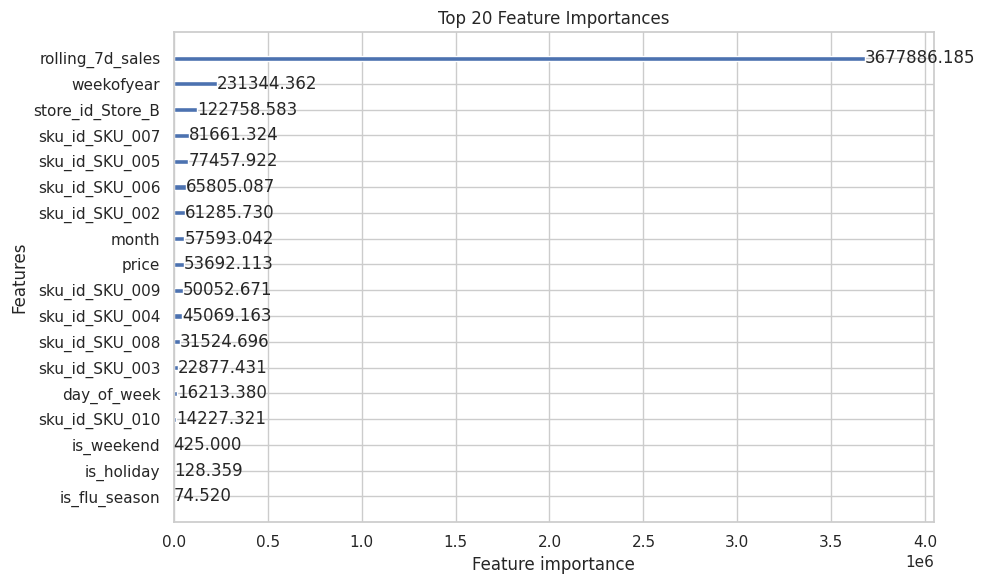

In [ ]:
import matplotlib.pyplot as plt

# Show top 20 most important features
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
sales_df.columns

Index(['date', 'sku_id', 'store_id', 'quantity_sold', 'day_of_week',
       'weekofyear', 'month', 'is_weekend', 'is_flu_season', 'is_holiday',
       'is_school_holiday', 'rolling_7d_sales', 'year', 'price', 'on_promo',
       'days_to_expiry'],
      dtype='object')

 Identify Top 3 SKUs by Total Sales
 - We group by sku_id, sum the quantity_sold, sort by descending order, and pick the top 3 SKUs. These are the products we'll forecast individually using Prophet.

In [ ]:
# Group by SKU and sum the total quantity sold
top_skus = sales_df.groupby('sku_id')['quantity_sold'].sum().nlargest(3).index.tolist()

print("Top 3 SKUs:", top_skus)


Top 3 SKUs: ['SKU_001', 'SKU_010', 'SKU_003']


Prepare Each SKU's Data for Prophet
Prophet only accepts two columns:

ds: datetime column

y: value to forecast

We prepare one dataset per top SKU in a dictionary.

We’re making Prophet-compatible data for each SKU, storing them in a dictionary for easy reuse.

In [ ]:
sku_dfs = {}  # To store prepared datasets for each SKU

for sku in top_skus:
    # Filter rows only for that SKU
    temp_df = sales_df[sales_df['sku_id'] == sku][['date', 'quantity_sold']].copy()

    # Rename columns as required by Prophet
    temp_df.rename(columns={'date': 'ds', 'quantity_sold': 'y'}, inplace=True)

    # Ensure the date column is in datetime format
    temp_df['ds'] = pd.to_datetime(temp_df['ds'])

    # Store in the dictionary
    sku_dfs[sku] = temp_df


Install and Import Prophet
- Install and import the prophet library (one-time install in Colab).
- Prophet is a time series forecasting model developed by Facebook. It works well for business series that have strong seasonal effects.

In [ ]:
# If not already installed
!pip install prophet


In [ ]:
from prophet import Prophet

Train Prophet Model for Each SKU and Forecast
- We train a separate model for each top SKU and forecast the next 30 days
- make_future_dataframe(periods=30) generates dates for the next 30 days.

- model.predict() generates future sales along with trend and uncertainty.

- Forecasts are plotted individually.
- This gives us a daily forecast for each SKU, which can be used for inventory planning, restocking, or redistribution based on expiry.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9r7jui6/9154y1fn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9r7jui6/t2t1tsc_.json



📈 Fitting Prophet model for SKU: SKU_001


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36820', 'data', 'file=/tmp/tmpf9r7jui6/9154y1fn.json', 'init=/tmp/tmpf9r7jui6/t2t1tsc_.json', 'output', 'file=/tmp/tmpf9r7jui6/prophet_modeleh8_5p2x/prophet_model-20250606091809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:18:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:18:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


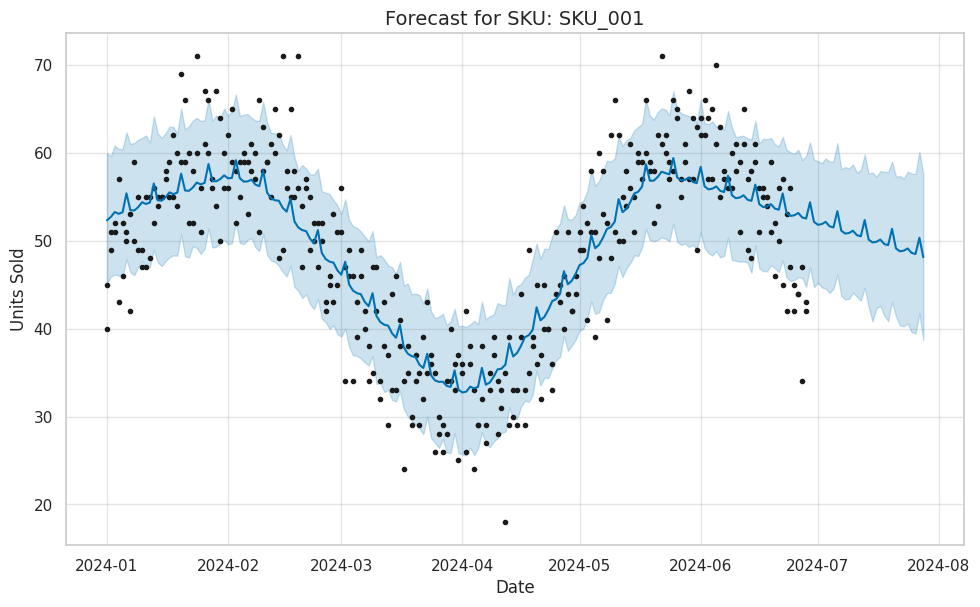

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9r7jui6/c2m1n225.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9r7jui6/im_vsh6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52002', 'data', 'file=/tmp/tmpf9r7jui6/c2m1n225.json', 'init=/tmp/tmpf9r7jui6/im_vsh6w.json', 'output', 'file=/tmp/tmpf9r7jui6/prophet_modeltx9u_777/prophet_model-20250606091810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:18:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:18:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📈 Fitting Prophet model for SKU: SKU_010


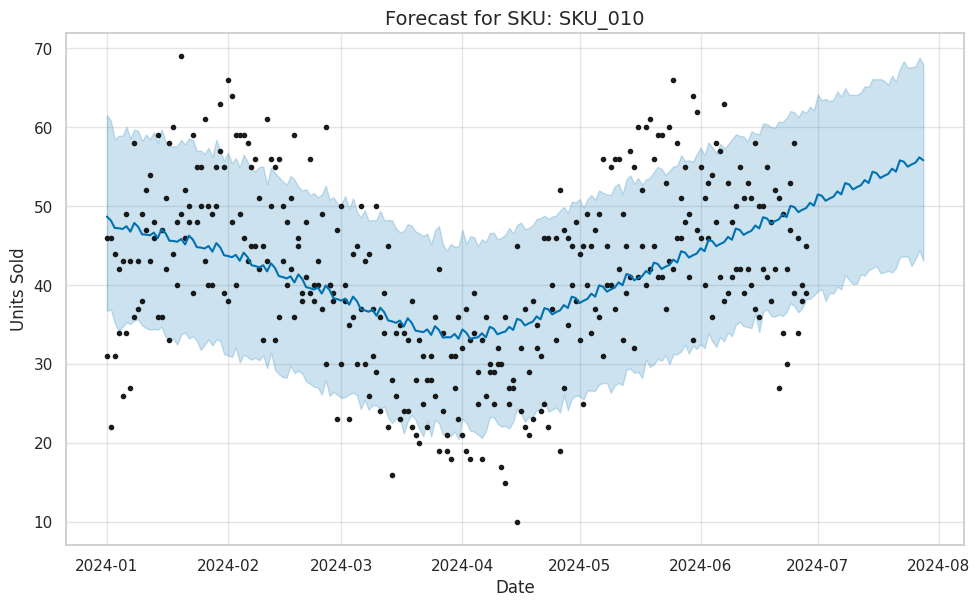

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9r7jui6/slwu3lev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpf9r7jui6/eg7k3huy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54822', 'data', 'file=/tmp/tmpf9r7jui6/slwu3lev.json', 'init=/tmp/tmpf9r7jui6/eg7k3huy.json', 'output', 'file=/tmp/tmpf9r7jui6/prophet_model8_16s3ua/prophet_model-20250606091811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:18:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:18:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📈 Fitting Prophet model for SKU: SKU_003


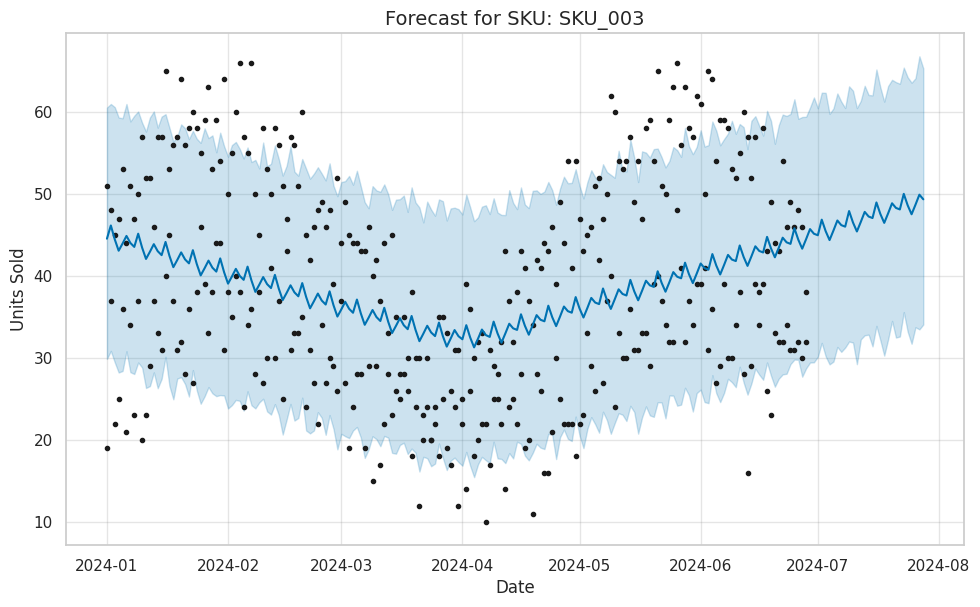

In [ ]:
forecast_results = {}

for sku, df in sku_dfs.items():
    print(f"\n📈 Fitting Prophet model for SKU: {sku}")

    # Initialize model
    model = Prophet()

    # Fit to historical data
    model.fit(df)

    # Create future dates for 30-day forecast
    future = model.make_future_dataframe(periods=30)

    # Predict future sales
    forecast = model.predict(future)

    # Store model and forecast
    forecast_results[sku] = (model, forecast)

    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f"Forecast for SKU: {sku}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.show()


Visualize Trend & Seasonality Components
- Prophet allows you to decompose the forecast into trend, weekly and yearly seasonality. This helps explain model behavior.
- This builds trust in the model — by seeing trends (e.g. increasing sales) or weekly patterns (e.g. weekend peaks), stakeholders can validate the model’s reasoning.



Components for SKU: SKU_001


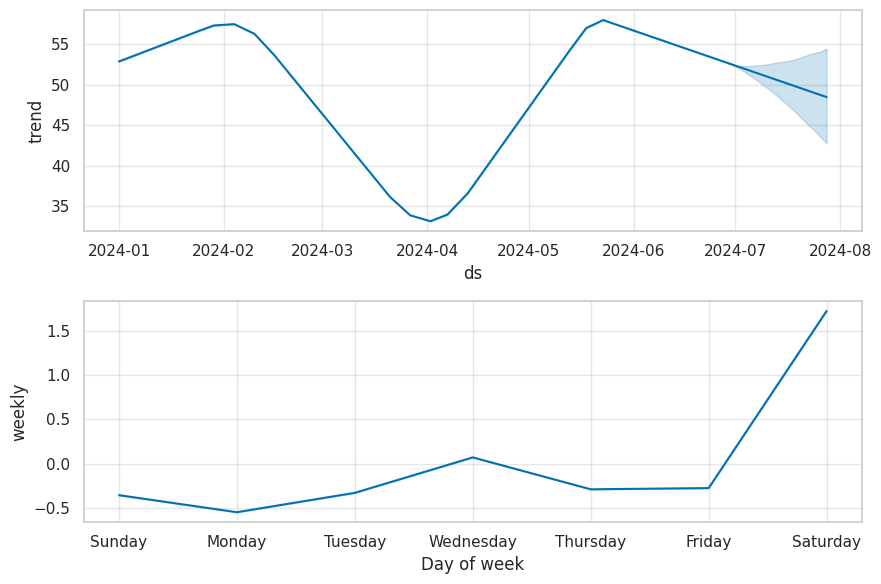

Components for SKU: SKU_010


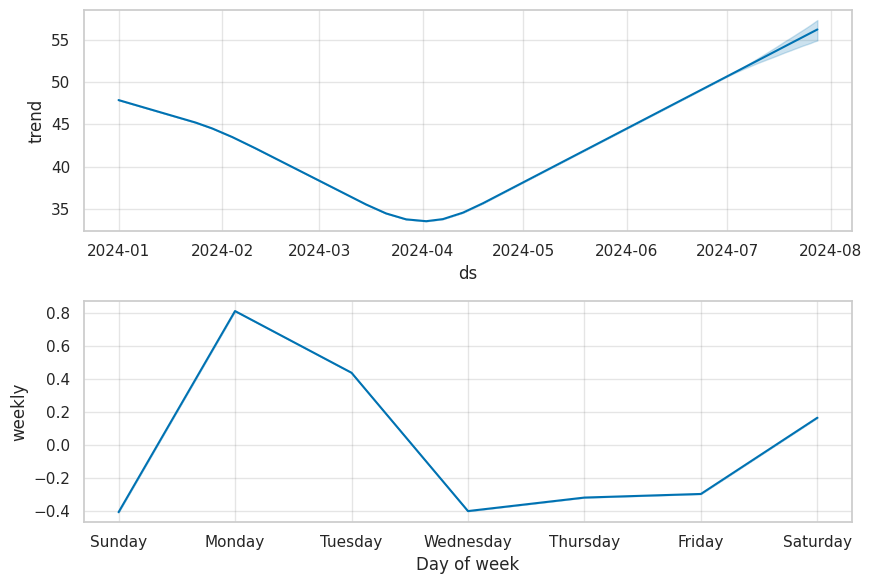

Components for SKU: SKU_003


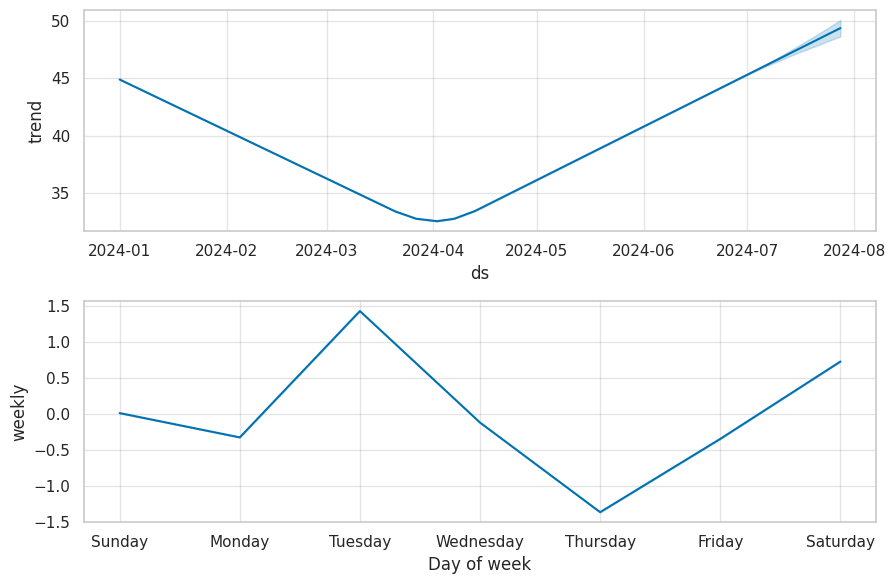

In [ ]:
for sku, (model, forecast) in forecast_results.items():
    print(f"Components for SKU: {sku}")

    # Plot decomposed components
    fig2 = model.plot_components(forecast)
    plt.show()


**Model Comparison with DataFrame and Plots**
- Create the Comparison DataFrame
- We use pandas DataFrame to organize the performance metrics (like RMSE and MAE) of each model in a tabular format. This structure makes it easy to view, sort, analyze, and export the results.
- We create a dictionary where each key is a column name (Model, RMSE, MAE).

- The values are lists of results from your previously trained models.

- This builds a clear table mapping models to their evaluation scores.
- If you ran Prophet models for specific SKUs, this loop adds those results dynamically to the DataFrame with clear labeling. ignore_index=True keeps the DataFrame index consistent.

In [ ]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'RMSE': [lr_rmse, rf_rmse, xgb_rmse, lgb_rmse],
    'MAE': [lr_mae, rf_mae, xgb_mae, lgb_mae]
})


Plot RMSE and MAE for Visual Comparison
- We use seaborn’s built-in styles (whitegrid) for professional-looking plots with gridlines.

In [ ]:
import seaborn as sns

# Set a clean plot style for readability
sns.set(style="whitegrid")

Sorting by RMSE helps you quickly identify the best performing model (lowest error).

reset_index(drop=True) resets the index after sorting for cleaner output.

Displaying results_sorted in Colab shows a neat, sorted table.

In [ ]:
# Sort the DataFrame by RMSE ascending - lower RMSE indicates better model accuracy
results_sorted = results.sort_values("RMSE").reset_index(drop=True)

# Display the sorted DataFrame
results_sorted


,Model,RMSE,MAE
0,LightGBM,5.750573,4.567254
1,XGBoost,6.386248,5.075320
2,Random Forest,7.536211,4.859222
3,Linear Regression,7.536211,6.189423


plt.figure(figsize=(10,5)) sets the plot size.

sns.barplot() draws horizontal bars representing RMSE values for each model.

The y-axis lists models; x-axis shows RMSE magnitude (lower is better).

palette="Blues_d" colors bars in different blue shades.

plt.tight_layout() adjusts padding for clean layout.

plt.show() renders the plot.

<ipython-input-238-345636225478>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_sorted, palette="Blues_d")


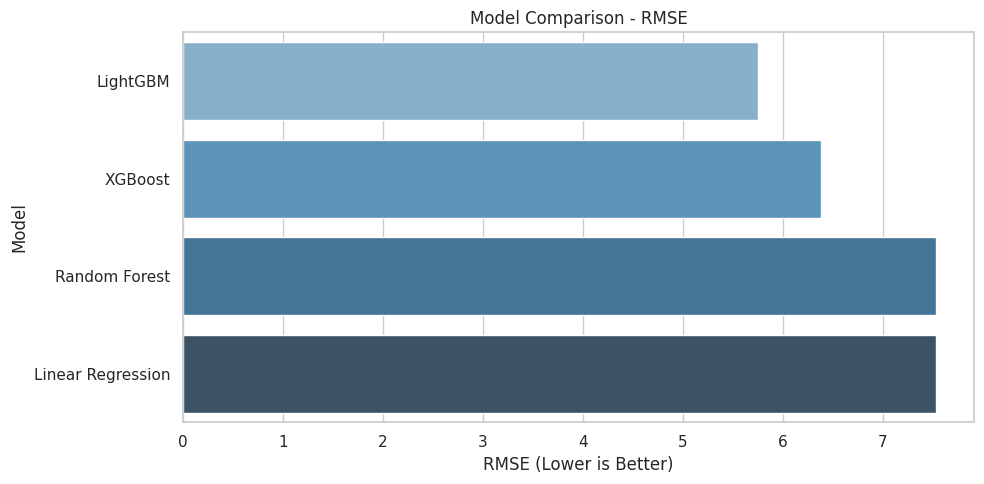

In [ ]:
# Plot RMSE scores
plt.figure(figsize=(10, 5))
sns.barplot(x='RMSE', y='Model', data=results_sorted, palette="Blues_d")
plt.title('Model Comparison - RMSE')
plt.xlabel('RMSE (Lower is Better)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()


Same as above but for MAE metric, with green colors to visually differentiate.

MAE complements RMSE by showing average absolute errors.

<ipython-input-239-f23da49a91c4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE', y='Model', data=results_sorted, palette="Greens_d")


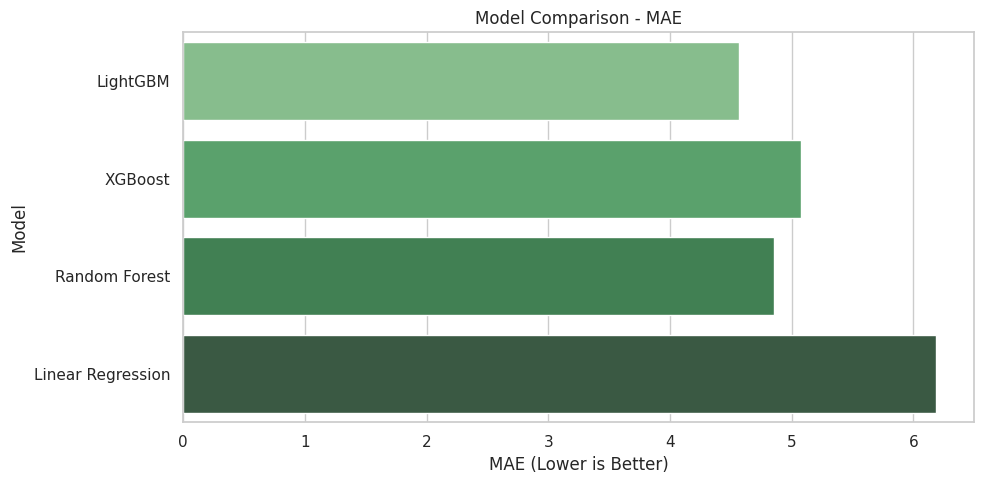

In [ ]:
# Plot MAE scores similarly
plt.figure(figsize=(10, 5))
sns.barplot(x='MAE', y='Model', data=results_sorted, palette="Greens_d")
plt.title('Model Comparison - MAE')
plt.xlabel('MAE (Lower is Better)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()


Use LightGBM as your production-grade forecasting model for accuracy, scalability, and flexibility.

🎯 Why LightGBM?
✅ High Accuracy: Outperforms most models in RMSE/MAE.

✅ Fast Training: Handles large retail datasets efficiently.

✅ Handles Categorical Features: Built-in support for things like store, SKU, day-of-week.

✅ Feature Importance: Offers explainability via SHAP.

✅ Modular: Fits well into MLOps pipelines and can be easily tuned and retrained.

**Hyperparameter Tuning**
- Import libraries
- RandomizedSearchCV helps us search for the best combination of hyperparameters randomly from a predefined grid.

- lightgbm is the model library we use.

- numpy for any needed numerical operations.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import numpy as np


Define the hyperparameter search space
- This grid defines the hyperparameters and their possible values for tuning.

- Each parameter controls a different aspect of model complexity and regularization.

In [ ]:
param_grid = {
    'num_leaves': [31, 50, 70],           # Maximum number of leaves in one tree; higher = more complex model but risks overfitting
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage to prevent overfitting; smaller values require more trees
    'n_estimators': [100, 200, 500],     # Number of boosting rounds (trees); more trees can improve accuracy but increase training time
    'max_depth': [-1, 10, 20, 30],       # Limits tree depth; -1 means no limit
    'min_child_samples': [20, 30, 40],   # Minimum number of data points in a leaf; helps control overfitting by pruning leaves with fewer points
    'subsample': [0.6, 0.8, 1.0],        # Fraction of data to sample per iteration; introduces randomness to reduce overfitting
    'colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features to sample per tree; helps reduce correlation among trees and overfitting
}


Initialize LightGBM model
- We create a LightGBM regression model object with a fixed random seed for reproducibility.

- At this stage, we don’t set hyperparameters because we want to find the best ones during tuning.



In [ ]:
lgb_estimator = lgb.LGBMRegressor(random_state=42)


 Setup RandomizedSearchCV
 - RandomizedSearchCV runs a randomized hyperparameter search to find good parameter combinations.

- n_iter=20 means it tries 20 different sets randomly picked from param_grid.

- Cross-validation (cv=3) prevents overfitting by validating performance on unseen subsets.

- n_jobs=-1 speeds up by parallel processing.

In [ ]:
random_search = RandomizedSearchCV(
    estimator=lgb_estimator,
    param_distributions=param_grid,
    n_iter=20,                         # Number of parameter combinations to try (randomly sampled)
    scoring='neg_root_mean_squared_error',  # We want to minimize RMSE, sklearn expects a score to maximize, so it uses negative RMSE
    cv=3,                             # 3-fold cross-validation: data split into 3 parts; each used as validation once to get robust score
    verbose=2,                       # Display progress logs
    random_state=42,                 # Ensures reproducible random search
    n_jobs=-1                       # Use all CPU cores to speed up training
)


Run the search on training data
- This trains multiple LightGBM models with different hyperparameters on X_train and y_train.

- For each combination, it performs cross-validation and evaluates RMSE.

- This can take some time depending on dataset size and computing resources.



In [ ]:
random_search.fit(X_train_encoded, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [20, 30, 40],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [31, 50, 70],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

Review best results
- best_score_ is the best negative RMSE found (because sklearn maximizes the score internally).

- The more negative, the worse the RMSE; so, you can invert sign to get the positive RMSE value.

- best_params_ shows the hyperparameters that gave the best validation performance.



In [ ]:
print("Best RMSE (negative): ", random_search.best_score_)
print("Best Parameters: ", random_search.best_params_)


Best RMSE (negative):  -7.46096596762149
Best Parameters:  {'subsample': 0.8, 'num_leaves': 50, 'n_estimators': 500, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


Train final model using best hyperparameters
- After identifying the best hyperparameters, we create a new LightGBM model with these settings.

- Then train on the entire training dataset to leverage all available data.

In [ ]:
best_params = random_search.best_params_

final_model = lgb.LGBMRegressor(**best_params, random_state=42)
final_model.fit(X_train_encoded, y_train)


LGBMRegressor(colsample_bytree=0.6, learning_rate=0.01, max_depth=10,
              min_child_samples=30, n_estimators=500, num_leaves=50,
              random_state=42, subsample=0.8)

SHAP explanability
- SHAP helps you understand how each feature contributes to a specific prediction or overall model behavior.

Install and import SHAP
- shap is a library for model explainability using Shapley values.

- We also import matplotlib.pyplot to visualize SHAP outputs.

In [248]:
!pip install shap

import shap
import lightgbm as lgb
import matplotlib.pyplot as plt


Initialize the SHAP explainer
- TreeExplainer is optimized for tree-based models like LightGBM.

- It calculates how much each feature "contributes" to a prediction by comparing to a baseline prediction.



In [249]:
# Create TreeExplainer for LightGBM model
explainer = shap.Explainer(final_model)


Calculate SHAP values for a subset of your data
- SHAP can be computationally heavy, so we limit it to 100 samples.

- These values represent the impact each feature had on the prediction for each sample.

In [251]:
# Compute SHAP values for 100 samples from test set for efficiency
shap_values = explainer(X_test_encoded.sample(100, random_state=42))


SHAP Summary Plot
- The summary plot shows the top 15 features.

- Each point is a prediction for one row; its color indicates the feature value (red = high, blue = low), and position shows SHAP value (impact).

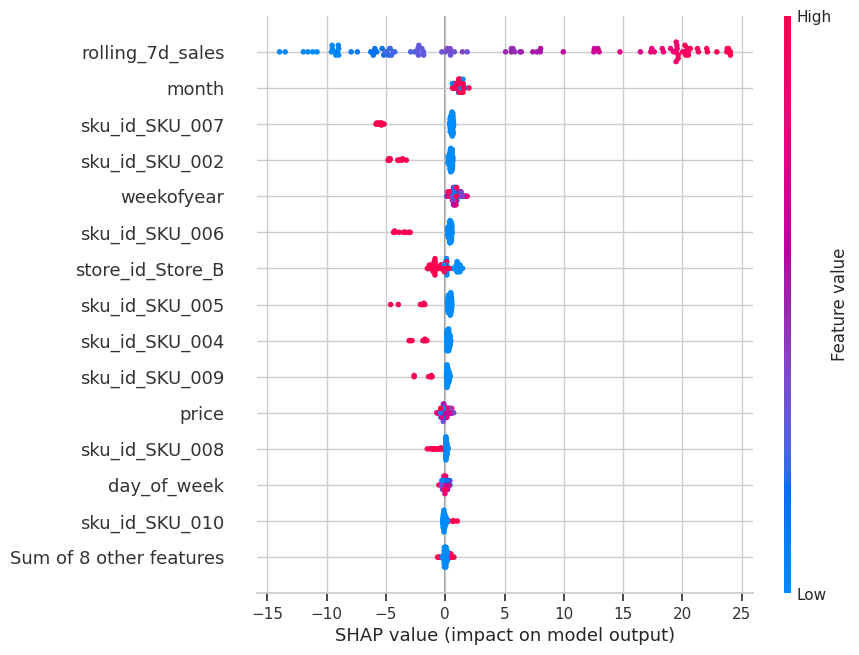

In [253]:
shap.plots.beeswarm(shap_values, max_display=15)


SHAP Feature Importance Bar Plot
- Bar chart of average absolute SHAP values shows which features are most influential in the model.

- Unlike standard feature importance, this reflects actual prediction impact.

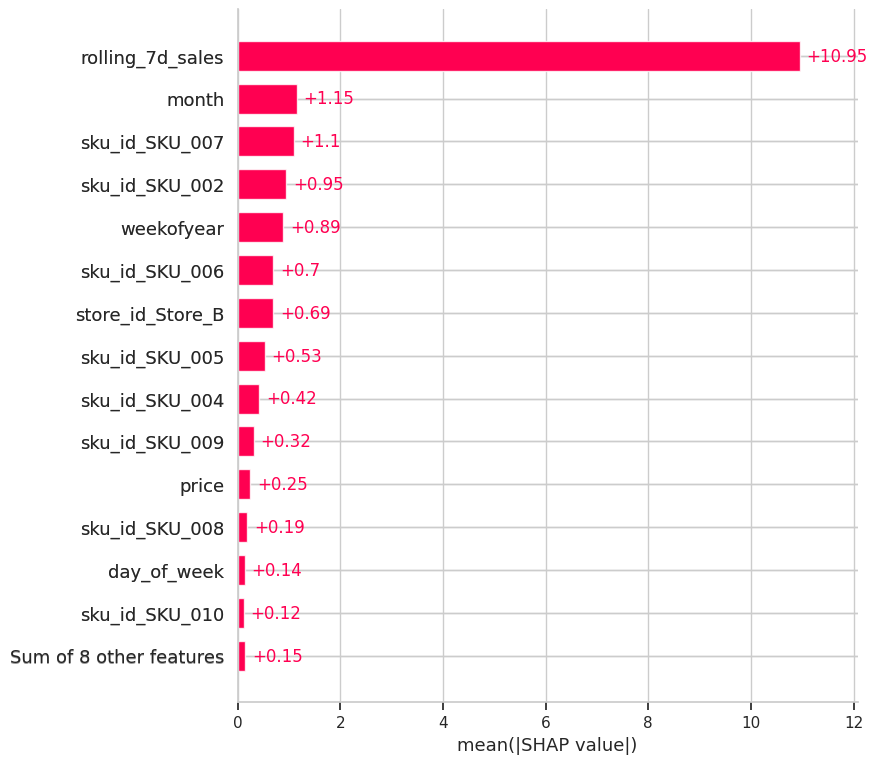

In [254]:
shap.plots.bar(shap_values, max_display=15)


Explain a single prediction
- The waterfall plot breaks down how each feature contributes to the final prediction for a single sample.



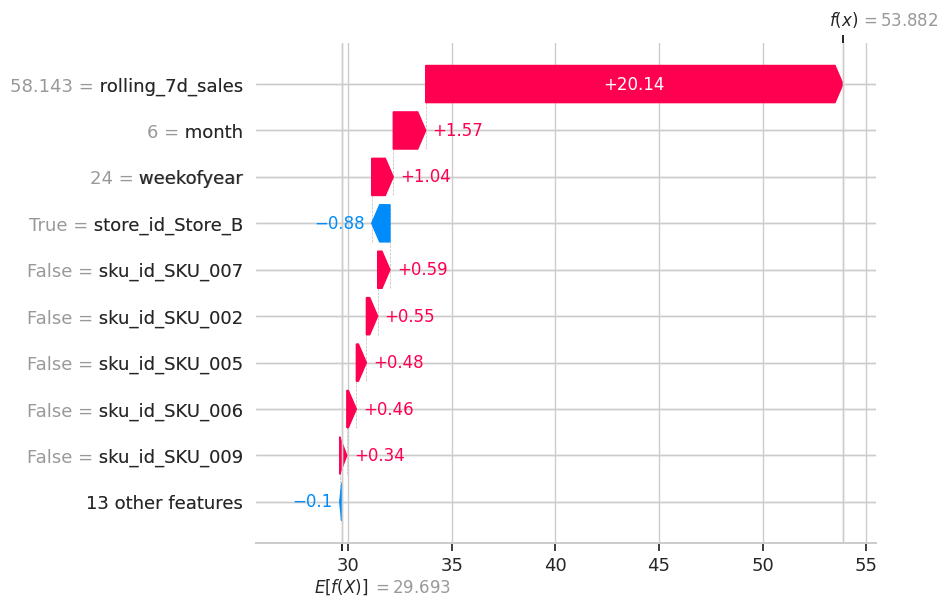

In [255]:
# Pick one sample from test set
sample_idx = 0
shap.plots.waterfall(shap_values[sample_idx])
